In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dataset-tachygraphy/Tachygraphy_dataset_main.csv


In [2]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
import numpy as np
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

In [4]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
df=pd.read_csv("/kaggle/input/dataset-tachygraphy/Tachygraphy_dataset_main.csv")
df.shape

(4958, 3)

In [6]:
df.head()

,Text,Meaning,Sentiment
0,Last session of the day http://twitpic.com/67ezh,Last session of the day http://twitpic.com/67ezh,neutral
1,Shanghai is also really exciting (precisely --...,Shanghai is also really exciting (precisely --...,positive
2,submit the report ASAP!,submit the report as soon as possilbe,negative
3,happy bday!,Happy Birthday!,positive
4,The OGs - I like it!!,The original gangsters - i like it!,positive


In [7]:
# df.drop(columns=['Sentiment.1'],inplace=True)

In [8]:
df=df.drop('Meaning',axis=1)

In [9]:
df.shape

(4958, 2)

In [10]:
df = df.rename(columns={'Text': 'tweet'})

In [11]:
df = df.rename(columns={'Sentiment': 'class'})

In [12]:
df['class'] = df['class'].str.lower()
sentiment_counts = df['class'].value_counts()
sentiment_counts

class
neutral     1743
positive    1643
negative    1572
Name: count, dtype: int64

In [13]:
df = df[df['class'] != "neutral"]  ###droping neutral columns

In [14]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(df['class'])
encoded_labels = label_encoder.transform(df['class'])
df['class'] = encoded_labels

In [15]:
df.head()

,tweet,class
1,Shanghai is also really exciting (precisely --...,1
2,submit the report ASAP!,0
3,happy bday!,1
4,The OGs - I like it!!,1
5,that`s great!! weee!! visitors!,1


In [16]:
df.isnull().sum()

tweet    1
class    0
dtype: int64

In [17]:
df=df.fillna('')

In [18]:
df.head()

,tweet,class
1,Shanghai is also really exciting (precisely --...,1
2,submit the report ASAP!,0
3,happy bday!,1
4,The OGs - I like it!!,1
5,that`s great!! weee!! visitors!,1


In [19]:
import re
from bs4 import BeautifulSoup

def text_cleaning(text):
    text = str(text)
    soup = BeautifulSoup(text, "html.parser")    ###removing html tages
    text = re.sub(r'\[[^]]*\]', '', soup.get_text())      ##removing text within square brackets
    pattern = r"[^a-zA-Z0-9\s,']"                  # Removing unwanted characters
    text = re.sub(pattern, '', text)
    url_pattern = r'http\S+|www\S+'            ###removing urls
    text = re.sub(url_pattern, '', text)
    return text

In [20]:
df['tweet'] = df['tweet'].apply(text_cleaning).tolist()

/tmp/ipykernel_24/2827669698.py:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")    ###removing html tages


In [21]:
df.head(10)

,tweet,class
1,Shanghai is also really exciting precisely sk...,1
2,submit the report ASAP,0
3,happy bday,1
4,The OGs I like it,1
5,thats great weee visitors,1
6,I THINK EVERYONE HATES ME ON HERE lol,0
7,"soooooo wish i could, but im in school and mys...",0
10,My bike was put on holdshould have known that ...,0
13,"Im in VA for the weekend, my youngest son turn...",0
14,Its coming out the socket I feel like my phone...,0


In [22]:
lens=[len(i.split()) for i in df['tweet']]

(array([135., 493., 641., 585., 429., 438., 237., 174.,  74.,   9.]),
 array([ 0. ,  3.2,  6.4,  9.6, 12.8, 16. , 19.2, 22.4, 25.6, 28.8, 32. ]),
 <BarContainer object of 10 artists>)

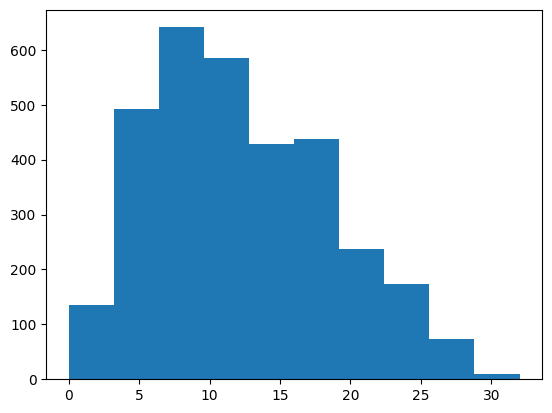

In [23]:
import matplotlib.pyplot as plt
plt.hist(lens)

In [24]:
import torch
import torch.nn as nn

import transformers
from transformers import AutoModel, BertTokenizerFast

In [25]:
# split into train, validation and test sets in the ration 70 : 15 : 15
from sklearn.model_selection import train_test_split

train_text, temp_text, train_labels, temp_labels = train_test_split(df['tweet'], df['class'], 
                                                                    random_state=2021, 
                                                                    test_size=0.2, 
                                                                    stratify=df['class'])


val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2021, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

In [26]:
bert = AutoModel.from_pretrained('bert-base-uncased')

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [27]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

(array([192., 469., 502., 424., 315., 268., 194., 145.,  55.,   8.]),
 array([ 1. ,  4.1,  7.2, 10.3, 13.4, 16.5, 19.6, 22.7, 25.8, 28.9, 32. ]),
 <BarContainer object of 10 artists>)

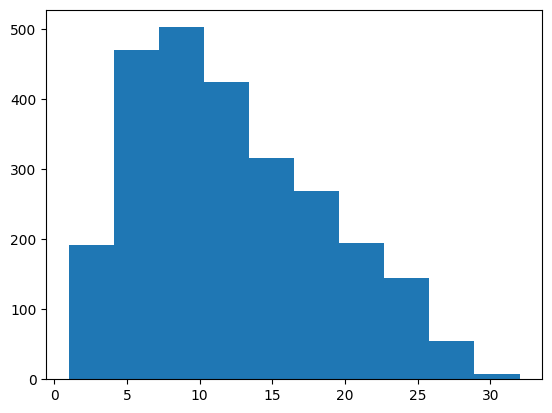

In [28]:
train_lens=[len(i.split()) for i in train_text]
plt.hist(train_lens)

In [29]:
import pandas as pd

sequence_lengths = df['tweet'].apply(lambda x: len(x.split()))
print(sequence_lengths.describe())


count    3215.000000
mean       12.223328
std         6.223879
min         0.000000
25%         7.000000
50%        11.000000
75%        17.000000
max        32.000000
Name: tweet, dtype: float64


In [30]:
pad_len = 50

In [31]:
# tokenizing and encoding sequences 
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = pad_len,
    pad_to_max_length=True,
    add_special_tokens=True,
    truncation=True,
    return_token_type_ids=True
)

tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = pad_len,
    pad_to_max_length=True,
    add_special_tokens=True,
    truncation=True,
    return_token_type_ids=True
)

tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = pad_len,
    pad_to_max_length=True,
    add_special_tokens=True,
    truncation=True,
    return_token_type_ids=True
)

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [32]:
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_token_type_ids = torch.tensor(tokens_train["token_type_ids"])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_token_type_ids = torch.tensor(tokens_val["token_type_ids"])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_token_type_ids = torch.tensor(tokens_test["token_type_ids"])
test_y = torch.tensor(test_labels.tolist())

In [33]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
batch_size = 64  ##batch size can be adjusted or modified
train_data = TensorDataset(train_seq, train_mask, train_token_type_ids, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
val_data = TensorDataset(val_seq, val_mask, val_token_type_ids, val_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [34]:
for param in bert.parameters():
    param.requires_grad = False

In [35]:
import torch.nn as nn

##model building
class SentimentClassifier(nn.Module):
     
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    
    # Forward propagaion
    def forward(self, input_ids, attention_mask, token_type_ids):
        _, pooled_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask,
            token_type_ids=token_type_ids
        ) 
        output = self.drop(pooled_output)  ##drop out layer
        return self.out(output)
    
class BERT_architecture(nn.Module):

    def __init__(self, bert):
        super(BERT_architecture, self).__init__()

        self.bert = bert 
        
        self.dropout = nn.Dropout(0.2) ##needs adjusment
        self.relu = nn.ReLU() ##activation function
        
        self.fc1 = nn.Linear(768, 512) #dense layer
        
        # Dense layer 2 (Output layer)
        self.fc2 = nn.Linear(512, 2)  #2 classes

        # Softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)  

    # Defining forward pass
    def forward(self, sent_id, mask, token_type_ids): 
        _, cls_hs = self.bert(sent_id, attention_mask=mask, token_type_ids=token_type_ids, return_dict=False)
        x = self.fc1(cls_hs)
        x = self.relu(x)
        x = self.dropout(x)
        # Output layer
        x = self.fc2(x)
        x = self.softmax(x)
        return x


In [36]:
model = BERT_architecture(bert)

In [37]:
test_seq = test_seq.to(device)
test_mask = test_mask.to(device)
test_token_type_ids = test_token_type_ids.to(device)
model.to(device)

BERT_architecture(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [38]:
from transformers import AdamW
optimizer = AdamW(model.parameters(),lr = 1e-3)  ## learning rate needs to be adjusted.

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [39]:
from sklearn.utils.class_weight import compute_class_weight
import torch
import torch.nn as nn

# Compute the class weights for three classes
class_weights = compute_class_weight(class_weight="balanced",
                                     classes=np.unique(train_labels),
                                     y=train_labels)
print("Class weights are {} for {}".format(class_weights, np.unique(train_labels)))

Class weights are [1.02225755 0.97869102] for [0 1]


In [40]:
pd.value_counts(train_labels)

/tmp/ipykernel_24/883685092.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(train_labels)


class
1    1314
0    1258
Name: count, dtype: int64

In [41]:
weights = torch.tensor(class_weights, dtype=torch.float)

weights = weights.to(device)
cross_entropy = nn.CrossEntropyLoss()

epochs = 50 ##increase the no of epochs for better accuracy 


In [42]:
def train():
    model.train()
    total_loss, total_accuracy = 0, 0
    total_preds, total_labels = [], []

    for step, batch in enumerate(train_dataloader, 0):
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

#         sent_id = batch[:,0].to(device, dtype = torch.long)
#         mask = data[:,1].to(device, dtype = torch.long)
#         token_type_ids = data[:,2].to(device, dtype = torch.long)
#         labels = data[:,3].to(device, dtype = torch.float)
        
#         token_type_ids = batch['token_type_ids'].to(device)
        batch = [r.to(device) for r in batch]
        sent_id, mask, token_type_ids, labels = batch

        model.zero_grad()
        preds = model(sent_id, mask, token_type_ids)
        loss = cross_entropy(preds, labels)
        total_loss = total_loss + loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        preds = preds.detach().cpu().numpy()
        total_preds.append(preds)
        total_labels.append(labels.detach().cpu().numpy())

    avg_loss = total_loss / len(train_dataloader)
    total_preds = np.concatenate(total_preds, axis=0)
    total_labels = np.concatenate(total_labels, axis=0)
    return avg_loss, total_preds, total_labels

def evaluate():
    print("\nEvaluating after the test: ")
    model.eval()
    total_loss, total_accuracy = 0, 0
    total_preds, total_labels = [], []

    for step, batch in enumerate(val_dataloader):
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))
            
#         sent_id = batch[:,0].to(device, dtype = torch.long)
#         mask = data[:,1].to(device, dtype = torch.long)
#         token_type_ids = data[:,2].to(device, dtype = torch.long)
#         labels = data[:,3].to(device, dtype = torch.float)

#         token_type_ids = batch['token_type_ids'].to(device)
        batch = [t.to(device) for t in batch]
        sent_id, mask, token_type_ids, labels = batch

        with torch.no_grad():
            preds = model(sent_id, mask, token_type_ids)
            loss = cross_entropy(preds, labels)
            total_loss = total_loss + loss.item()
            preds = preds.detach().cpu().numpy()
            total_preds.append(preds)
            total_labels.append(labels.detach().cpu().numpy())

    avg_loss = total_loss / len(val_dataloader)
    total_preds = np.concatenate(total_preds, axis=0)
    total_labels = np.concatenate(total_labels, axis=0)
    return avg_loss, total_preds, total_labels
def calculate_accuracy(preds, labels):

    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    accuracy = np.sum(preds_flat == labels_flat) / len(labels_flat)
    return accuracy


In [43]:
best_valid_loss = float('inf')
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

for epoch in range(epochs):
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    train_loss, train_preds, train_labels = train()
    valid_loss, valid_preds, valid_labels = evaluate()
    train_accuracy = calculate_accuracy(train_preds, train_labels)
    valid_accuracy = calculate_accuracy(valid_preds, valid_labels)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracies.append(train_accuracy)
    valid_accuracies.append(valid_accuracy)
    
    print('\nTraining Loss: {}'.format(train_loss))
    print('Validation Loss: {}'.format(valid_loss))
    print('Training Accuracy: {:.2f}%'.format(train_accuracy * 100))
    print('Validation Accuracy: {:.2f}%'.format(valid_accuracy * 100))



 Epoch 1 / 50

Evaluating after the test: 

Training Loss: 0.7068253973635231
Validation Loss: 0.6459677616755167
Training Accuracy: 55.02%
Validation Accuracy: 60.75%

 Epoch 2 / 50

Evaluating after the test: 

Training Loss: 0.6533140598273859
Validation Loss: 0.5913613984982172
Training Accuracy: 61.55%
Validation Accuracy: 61.68%

 Epoch 3 / 50

Evaluating after the test: 

Training Loss: 0.6285087349938183
Validation Loss: 0.5930723150571188
Training Accuracy: 65.47%
Validation Accuracy: 65.11%

 Epoch 4 / 50

Evaluating after the test: 

Training Loss: 0.5952817187076662
Validation Loss: 0.5215519592165947
Training Accuracy: 68.16%
Validation Accuracy: 71.03%

 Epoch 5 / 50

Evaluating after the test: 

Training Loss: 0.5659989358448401
Validation Loss: 0.6653813322385153
Training Accuracy: 69.63%
Validation Accuracy: 58.26%

 Epoch 6 / 50

Evaluating after the test: 

Training Loss: 0.5592629131747455
Validation Loss: 0.5036026413242022
Training Accuracy: 71.03%
Validation Acc

In [44]:
from sklearn.metrics import classification_report
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device), test_token_type_ids.to(device))
  preds = preds.detach().cpu().numpy()
pred = np.argmax(preds, axis = 1)
print(classification_report(test_y, pred))

              precision    recall  f1-score   support

           0       0.76      0.79      0.78       157
           1       0.79      0.76      0.78       165

    accuracy                           0.78       322
   macro avg       0.78      0.78      0.78       322
weighted avg       0.78      0.78      0.78       322



In [45]:
def predict_user_input(input_text, model, tokenizer, device):
    inputs = tokenizer.encode_plus(
        input_text,
        add_special_tokens=True,
        max_length=max_seq_len,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_token_type_ids=True,
        return_tensors='pt',
    )
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    token_type_ids = inputs['token_type_ids'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask, token_type_ids)
        preds = torch.argmax(outputs, dim=1)
    
    return preds.item()
max_seq_len=50
input_text = "what a badass character Arthur is, rckstr is the bst"
predicted_class = predict_user_input(input_text, model, tokenizer, device)
if(predicted_class==0):
    print('Predicted sentiment: Negative')
else:
    print('Predicted sentiment: Positive')

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Predicted sentiment: Positive


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
